In [215]:
import torch
import torch.nn as nn

from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

In [354]:
device = torch.device("cuda")

In [355]:
class VGG_Conv_Block(nn.Module):
    def __init__(self, conv_channels=[]):
        super().__init__()
        
        layers = []
        for inc, outc in conv_channels:
            layers.append(nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            
        self.layer_stack = nn.Sequential(*layers, nn.MaxPool2d(kernel_size=2, stride=2))
        
    def forward(self, x):
        return self.layer_stack(x)
    
    
class VGG_Linear_Block(nn.Module):
    def __init__(self, in_features=4096, out_features=4096):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    def forward(self, x):
        return self.layer_stack(x)
    

class VGGnet(nn.Module):
    def __init__(self, conv_blocks=[], lin_blocks=[]):
        super().__init__()
        
        convs = []
        for block in conv_blocks:
            convs.append(VGG_Conv_Block((block[0], block[1])))   
        lins = []
        for block in lin_blocks:
            lins.append(VGG_Linear_Block(block[0], block[1]))    
        self.layer_stack = nn.Sequential(
            *convs,
            nn.Flatten(),
            *lins,
            nn.LogSoftmax(dim=1)
        )     
        
    def forward(self, x):
        return self.layer_stack(x)

In [356]:
dataset_train = FashionMNIST(root="../datasets", train=True, download=False, transform=ToTensor())
dataset_test = FashionMNIST(root="../datasets", train=False, download=False, transform=ToTensor())

In [341]:
BS = 64

train_dataloader = DataLoader(dataset_train, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BS, shuffle=True)

In [366]:
conv_blocks = [
    [(1, 5), (5, 5)], # 14x14 
    [(5, 10), (10, 10)] # 7x7
]
linear_blocks = [
    [7*7*10, 256],
    [256, 128],
    [128, 10]
]
output_classes = 10

model = VGGnet(conv_blocks, linear_blocks)
model = model.to(device)
model

VGGnet(
  (layer_stack): Sequential(
    (0): VGG_Conv_Block(
      (layer_stack): Sequential(
        (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGG_Conv_Block(
      (layer_stack): Sequential(
        (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): VGG_Linear_Block(
      (layer_stack): Sequential(
        (0): Linear(in_features=490, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (4)

In [ ]:
model.train()

N_EPOCHS = 30

B_EPOCHS = int(60_000/BS)

def acc_fn(pred, target): return (pred.argmax(dim=1)==target).sum()
loss_fn = nn.NLLLoss()

optim = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.1)

losses = []
accs = []

for e in tqdm(range(N_EPOCHS)):
    
    for b, (x, y) in enumerate(train_dataloader):
        
        optim.zero_grad()
        
        pred = model(x.to(device))
        loss = loss_fn(pred, y.to(device))
        
        acc = acc_fn(pred.detach().cpu(), y.detach().cpu()).item() / BS * 100.0
        accs.append(acc)
        
        losses.append(loss.item()/BS)
        
        loss.backward()
        
        optim.step()
        
        if b % 150 == 0: print(f"Epoch:{e}/{N_EPOCHS}, Batch:{b}/{B_EPOCHS}, Loss:{loss.item()/BS}, Acc:{acc}")

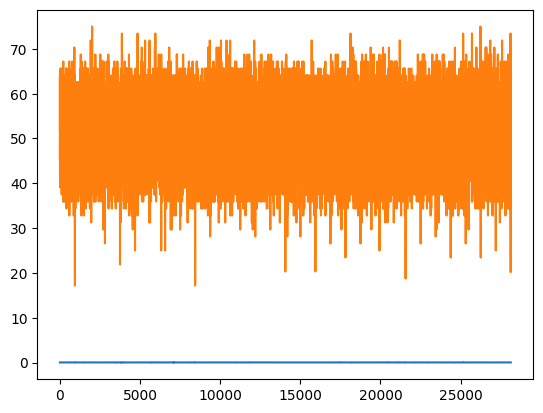

In [379]:
plt.plot(losses)
plt.plot(accs)

In [380]:
model.eval()

score = 0

for (x, y) in test_dataloader:
    score += acc_fn(model(x.to(device)).detach().cpu(), y)
    
score

tensor(9085)